# Hyperbolic Semantic Communication: Formal Implementation

## From Proof of Concept to Paper Proposal

**Author:** Éric Gustavo Reis de Sena  
**Date:** January 2026  
**License:** CC BY-NC-SA 4.0

---

This notebook operationalizes the core geometric proposal of the paper within current computational constraints.

**Key advancement from PoC:**
- Uses formal Lorentz geometry (not conformal approximation)
- Embedding via exponential map from origin
- Geodesic-based transport
- Product manifold: $\mathcal{M} = \mathbb{H}^2_K \times \mathbb{R}^{H \times W}$

In [1]:
# @title 1.1 Upload CGT Project
from google.colab import files
import zipfile
import os

!rm -rf /content/src
print('Upload cgt_project_formal.zip:')

uploaded = files.upload()
for f in uploaded:
    if f.endswith('.zip'):
        with zipfile.ZipFile(f, 'r') as z:
            z.extractall('/content')
        print(f'✅ Extracted: {f}')
        os.remove(f)

# Verify
required = [
    '/content/src/cgt/geometry/lorentz_hardened.py',
    '/content/src/cgt/transport/__init__.py'
]
for path in required:
    if os.path.exists(path):
        print(f'✅ {path}')
    else:
        print(f'❌ MISSING: {path}')

Upload cgt_project_formal.zip:


Saving cgt_project_formal.zip to cgt_project_formal.zip
✅ Extracted: cgt_project_formal.zip
✅ /content/src/cgt/geometry/lorentz_hardened.py
✅ /content/src/cgt/transport/__init__.py


In [2]:
# @title 1.2 Import CGT Modules
import sys
sys.path.insert(0, '/content/src')

import numpy as np
import matplotlib.pyplot as plt
import torch

# Import from CGT project - FORMAL GEOMETRY
from cgt.geometry import (
    LorentzConfig,
    LorentzSubstrateHardened,
    frechet_mean,
)
from cgt.transport import (
    HyperbolicSpatialTransport,
    SpatialTransportConfig,
    create_transport,
)
from cgt.utils.helpers import (
    set_global_seed,
    academic_use_disclaimer,
    watermark_plot,
)

academic_use_disclaimer()
set_global_seed(42)
print(f'✅ Formal Lorentz geometry loaded')


    ╔══════════════════════════════════════════════════════════════════════════╗
    ║              CONTRASTIVE GEOMETRIC TRANSFER (CGT) v1.0                   ║
    ╠══════════════════════════════════════════════════════════════════════════╣
    ║  Copyright © 2026 Éric Gustavo Reis de Sena                              ║
    ║  License: CC BY-NC-SA 4.0 (Academic/Non-Commercial Use Only)             ║
    ║                                                                          ║
    ║  ⚠️  COMMERCIAL USE IS STRICTLY PROHIBITED                               ║
    ║  📧  For commercial licensing: eirikreisena@gmail.com                    ║
    ╚══════════════════════════════════════════════════════════════════════════╝
    
✅ Formal Lorentz geometry loaded


In [3]:
# @title 2.1 Load Test Images
!pip install -q scikit-image
from skimage import data, color, transform
from skimage.util import img_as_float64

def load_image(image, size=256):
    img = img_as_float64(image)
    if img.ndim == 3: img = color.rgb2gray(img)
    return transform.resize(img, (size, size), anti_aliasing=True)

SIZE = 256
images = {
    'Camera': load_image(data.camera(), SIZE),
    'Astronaut': load_image(data.astronaut(), SIZE),
    'Coffee': load_image(data.coffee(), SIZE),
    'Cat': load_image(data.cat(), SIZE),
}
print(f'✅ Loaded {len(images)} images ({SIZE}×{SIZE})')

✅ Loaded 4 images (256×256)


---
## 3. Formal Lorentz Geometry Verification

Before proceeding, we verify the Lorentz substrate satisfies manifold constraints.

In [4]:
# @title 3.1 Lorentz Manifold Diagnostics

# Initialize Lorentz substrate
lorentz = LorentzSubstrateHardened(LorentzConfig(
    intrinsic_dim=2,
    initial_curvature=1.0,
    learnable_curvature=False,
))

print('Lorentz Manifold H²_K Configuration:')
print(f'  Intrinsic dimension: {lorentz.n}')
print(f'  Ambient dimension: {lorentz.n + 1}')
print(f'  Sectional curvature K: {lorentz.K.item():.4f}')

# Test: Create points and verify manifold constraint
test_vectors = torch.randn(100, 2, dtype=torch.float64) * 0.5
test_points = lorentz.exp_map_batch(test_vectors)

violation = lorentz.manifold_violation(test_points)
print(f'\nManifold violation (should be ≈0): {violation.item():.2e}')

# Test: Distance is symmetric and positive
d12 = lorentz.dist(test_points[0:1], test_points[1:2])
d21 = lorentz.dist(test_points[1:2], test_points[0:1])
print(f'Distance symmetry |d(x,y) - d(y,x)|: {abs(d12 - d21).item():.2e}')

print('\n✅ Lorentz geometry verified')

Lorentz Manifold H²_K Configuration:
  Intrinsic dimension: 2
  Ambient dimension: 3
  Sectional curvature K: 1.0000

Manifold violation (should be ≈0): 1.00e-06
Distance symmetry |d(x,y) - d(y,x)|: 0.00e+00

✅ Lorentz geometry verified


Round-trip error (exp → log): 1.77e-06 ± 1.33e-07


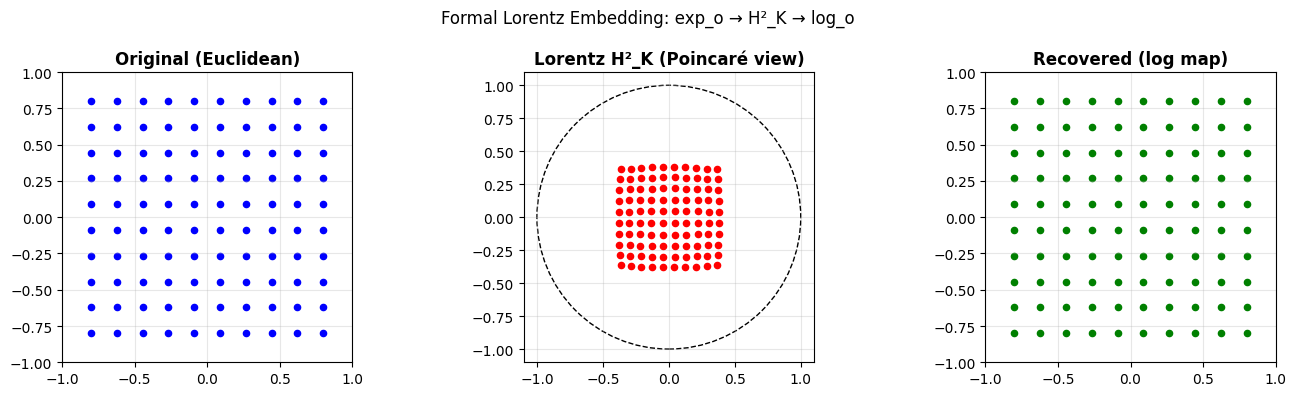

In [5]:
# @title 3.2 Visualize Embedding: Euclidean → Lorentz → Euclidean

# Create grid of 2D points
n_grid = 10
coords = torch.linspace(-0.8, 0.8, n_grid, dtype=torch.float64)
X, Y = torch.meshgrid(coords, coords, indexing='ij')
points_2d = torch.stack([X.flatten(), Y.flatten()], dim=-1)

# Embed into Lorentz manifold
points_lorentz = lorentz.exp_map_batch(points_2d)

# Project back via log map
points_recovered = lorentz.log_map_zero(points_lorentz)[..., 1:]  # Drop time component

# Compute reconstruction error
error = (points_2d - points_recovered).norm(dim=-1)
print(f'Round-trip error (exp → log): {error.mean():.2e} ± {error.std():.2e}')

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original 2D
ax = axes[0]
ax.scatter(points_2d[:, 0], points_2d[:, 1], c='blue', s=20)
ax.set_title('Original (Euclidean)', fontweight='bold')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Lorentz embedding (Poincaré projection for visualization)
ax = axes[1]
points_poincare = lorentz.to_poincare(points_lorentz)
ax.scatter(points_poincare[:, 0], points_poincare[:, 1], c='red', s=20)
circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
ax.add_patch(circle)
ax.set_title('Lorentz H²_K (Poincaré view)', fontweight='bold')
ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Recovered
ax = axes[2]
ax.scatter(points_recovered[:, 0], points_recovered[:, 1], c='green', s=20)
ax.set_title('Recovered (log map)', fontweight='bold')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.suptitle('Formal Lorentz Embedding: exp_o → H²_K → log_o', fontsize=12)
plt.tight_layout()
plt.show()

---
## 4. Hyperbolic Spatial Transport

Using formal geodesic transport on H²_K for image coordinates.

In [6]:
# @title 4.1 Initialize Transport Module

transport = create_transport(image_size=SIZE, curvature=1.0)

print('Hyperbolic Spatial Transport initialized:')
print(f'  Image size: {SIZE}×{SIZE}')
print(f'  Curvature K: {transport.lorentz.K.item():.4f}')
print(f'  Manifold: H²_K (Lorentz model)')
print(f'\nProduct manifold architecture:')
print(f'  M = H²_K × R^({SIZE}×{SIZE})')
print(f'  - H²_K: Spatial structure (geodesic transport)')
print(f'  - R^m: Pixel-critical residual (Euclidean)')

Hyperbolic Spatial Transport initialized:
  Image size: 256×256
  Curvature K: 1.0000
  Manifold: H²_K (Lorentz model)

Product manifold architecture:
  M = H²_K × R^(256×256)
  - H²_K: Spatial structure (geodesic transport)
  - R^m: Pixel-critical residual (Euclidean)


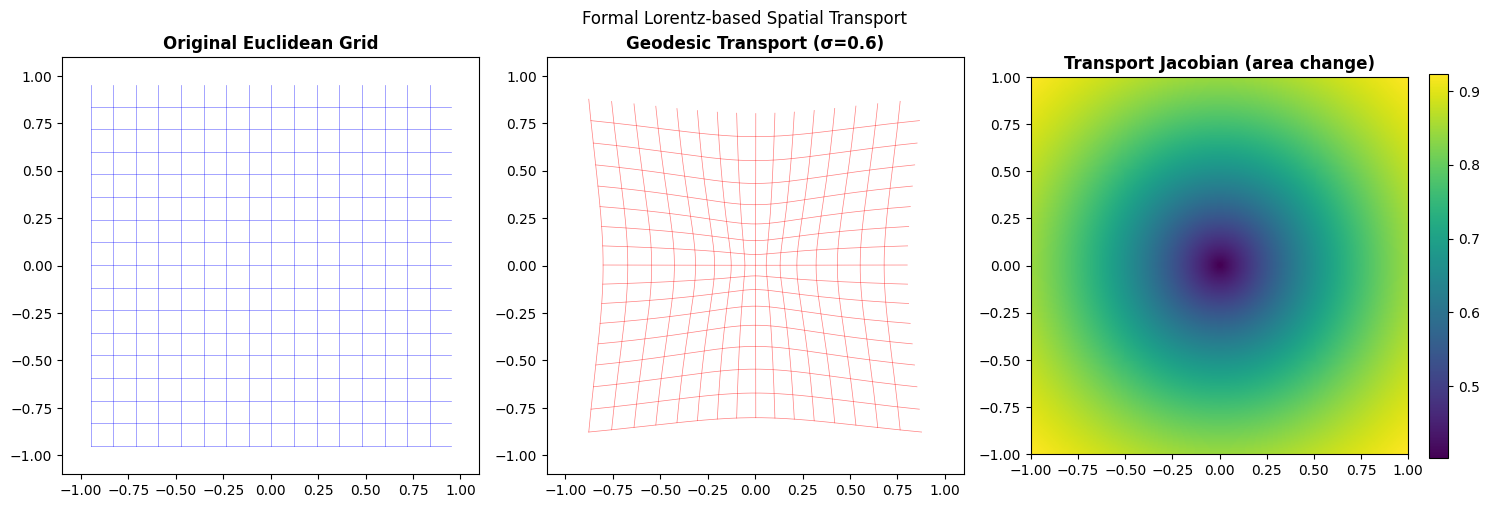

In [7]:
# @title 4.2 Visualize Geodesic Transport

FOVEAL_STRENGTH = 0.6

# Compute transport
coords_transported, jacobian = transport.compute_foveal_transport(FOVEAL_STRENGTH)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original grid
ax = axes[0]
coords_orig = transport.coords_euclidean
step = SIZE // 16
for i in range(0, SIZE, step):
    ax.plot(coords_orig[i, :, 0], coords_orig[i, :, 1], 'b-', alpha=0.5, lw=0.5)
    ax.plot(coords_orig[:, i, 0], coords_orig[:, i, 1], 'b-', alpha=0.5, lw=0.5)
ax.set_title('Original Euclidean Grid', fontweight='bold')
ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')

# Transported grid
ax = axes[1]
for i in range(0, SIZE, step):
    ax.plot(coords_transported[i, :, 0], coords_transported[i, :, 1], 'r-', alpha=0.5, lw=0.5)
    ax.plot(coords_transported[:, i, 0], coords_transported[:, i, 1], 'r-', alpha=0.5, lw=0.5)
ax.set_title(f'Geodesic Transport (σ={FOVEAL_STRENGTH})', fontweight='bold')
ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')

# Jacobian (area change)
ax = axes[2]
im = ax.imshow(jacobian.numpy(), cmap='viridis', extent=[-1, 1, -1, 1])
ax.set_title('Transport Jacobian (area change)', fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Formal Lorentz-based Spatial Transport', fontsize=12)
plt.tight_layout()
plt.savefig('lorentz_transport_grid.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Process Images Through Formal Pipeline

In [8]:
# @title 5.1 Process All Images

results = {}

for name, img in images.items():
    img_tensor = torch.from_numpy(img)

    # Run formal pipeline
    res = transport.forward_pipeline(img_tensor, foveal_strength=FOVEAL_STRENGTH)

    # Compute metrics
    metrics = transport.compute_metrics(
        res['original'],
        res['reconstructed'],
        central_fraction=0.25
    )

    results[name] = {**res, **metrics}
    print(f'  ✓ {name}: PSNR={metrics["psnr"]:.2f} dB, C/P ratio={metrics["central_peripheral_ratio"]:.4f}')

print('\n✅ All images processed with formal Lorentz transport')

  ✓ Camera: PSNR=15.18 dB, C/P ratio=0.9673
  ✓ Astronaut: PSNR=11.54 dB, C/P ratio=0.5321
  ✓ Coffee: PSNR=14.76 dB, C/P ratio=0.8907
  ✓ Cat: PSNR=17.73 dB, C/P ratio=0.8701

✅ All images processed with formal Lorentz transport


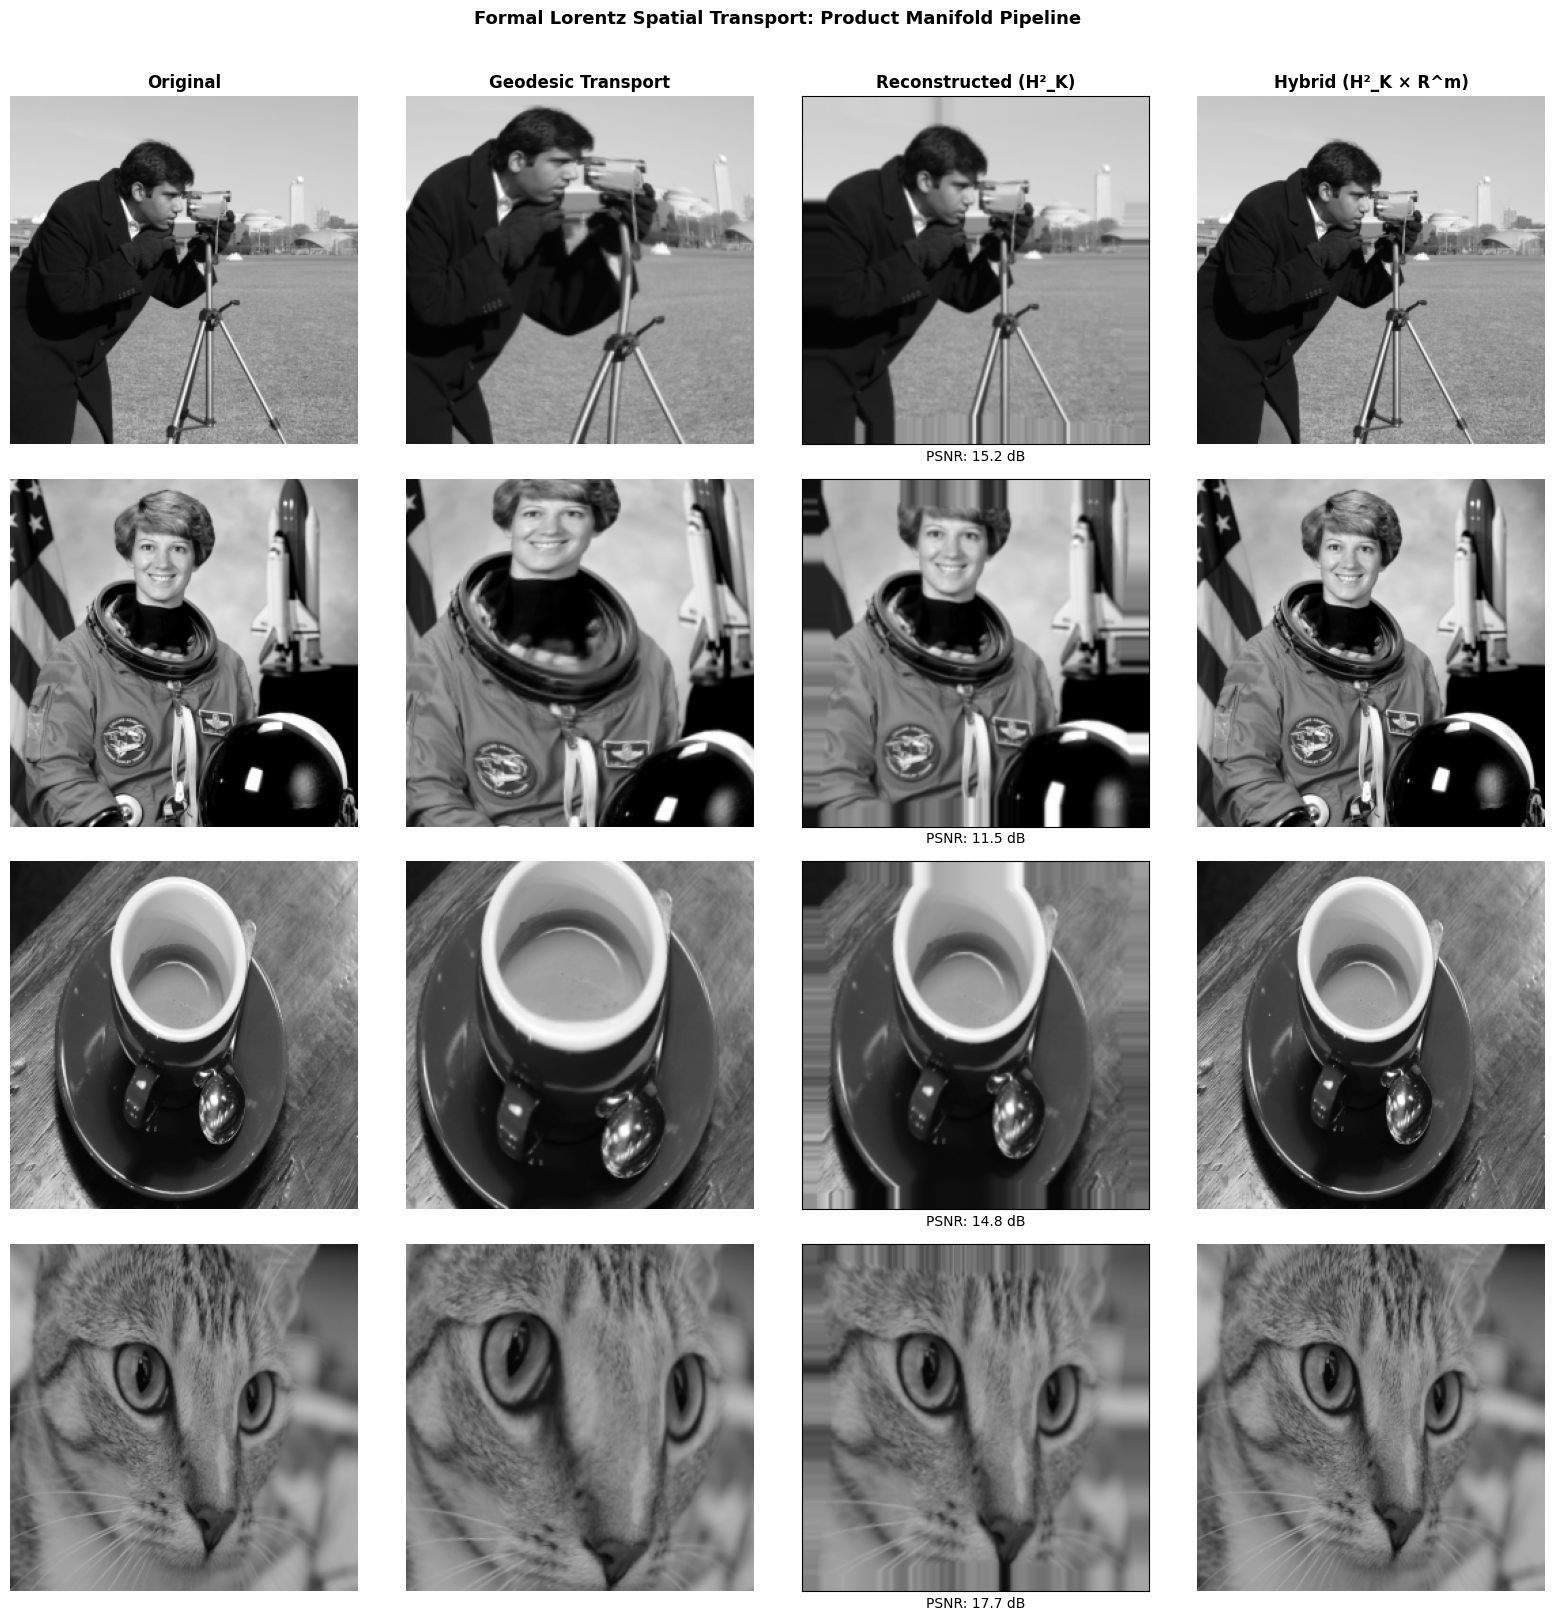

In [9]:
# @title 5.2 Visualize Pipeline Results

n = len(images)
fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))

for idx, (name, res) in enumerate(results.items()):
    # Original
    axes[idx, 0].imshow(res['original'].numpy(), cmap='gray', vmin=0, vmax=1)
    if idx == 0: axes[idx, 0].set_title('Original', fontweight='bold')
    axes[idx, 0].set_ylabel(name, fontsize=11, fontweight='bold')
    axes[idx, 0].axis('off')

    # Warped
    axes[idx, 1].imshow(res['warped'].numpy(), cmap='gray', vmin=0, vmax=1)
    if idx == 0: axes[idx, 1].set_title('Geodesic Transport', fontweight='bold')
    axes[idx, 1].axis('off')

    # Reconstructed
    axes[idx, 2].imshow(res['reconstructed'].numpy(), cmap='gray', vmin=0, vmax=1)
    if idx == 0: axes[idx, 2].set_title('Reconstructed (H²_K)', fontweight='bold')
    axes[idx, 2].set_xlabel(f'PSNR: {res["psnr"]:.1f} dB')
    axes[idx, 2].set_xticks([]); axes[idx, 2].set_yticks([])

    # Hybrid
    axes[idx, 3].imshow(res['hybrid'].numpy(), cmap='gray', vmin=0, vmax=1)
    if idx == 0: axes[idx, 3].set_title('Hybrid (H²_K × R^m)', fontweight='bold')
    axes[idx, 3].axis('off')

plt.suptitle('Formal Lorentz Spatial Transport: Product Manifold Pipeline', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('formal_pipeline_results.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Validation: Formal vs Baseline Comparison

In [10]:
# @title 6.1 Uniform Resize Baseline

def uniform_resize_baseline(image, scale=0.5):
    """Downscale + upscale uniformly."""
    H, W = image.shape
    small = transform.resize(image, (int(H*scale), int(W*scale)), anti_aliasing=True)
    return transform.resize(small, (H, W), anti_aliasing=True)

baseline = {}
for name, img in images.items():
    recon = uniform_resize_baseline(img, 0.5)
    baseline[name] = transport.compute_metrics(
        torch.from_numpy(img),
        torch.from_numpy(recon),
        central_fraction=0.25
    )
    print(f'  ✓ {name}: Baseline C/P ratio={baseline[name]["central_peripheral_ratio"]:.4f}')

  ✓ Camera: Baseline C/P ratio=2.6486
  ✓ Astronaut: Baseline C/P ratio=1.5740
  ✓ Coffee: Baseline C/P ratio=1.4836
  ✓ Cat: Baseline C/P ratio=1.8155


In [11]:
# @title 6.2 Comparison Summary

print('=' * 80)
print('FORMAL LORENTZ TRANSPORT vs UNIFORM RESIZE')
print('=' * 80)
print(f'{"Image":<12} {"Lorentz C/P":<14} {"Uniform C/P":<14} {"Improvement":<14}')
print('-' * 80)

improvements = []
for name in images.keys():
    lorentz_ratio = results[name]['central_peripheral_ratio']
    uniform_ratio = baseline[name]['central_peripheral_ratio']
    improvement = uniform_ratio / lorentz_ratio if lorentz_ratio > 0 else 0
    improvements.append(improvement)
    print(f'{name:<12} {lorentz_ratio:<14.4f} {uniform_ratio:<14.4f} {improvement:<14.2f}×')

print('-' * 80)
print(f'Average improvement in C/P ratio: {np.mean(improvements):.2f}×')
print('=' * 80)
print('\nInterpretation:')
print('  C/P ratio < 1 means error is concentrated in periphery (good for foveal)')
print('  Improvement > 1 means Lorentz transport redistributes error away from center')

FORMAL LORENTZ TRANSPORT vs UNIFORM RESIZE
Image        Lorentz C/P    Uniform C/P    Improvement   
--------------------------------------------------------------------------------
Camera       0.9673         2.6486         2.74          ×
Astronaut    0.5321         1.5740         2.96          ×
Coffee       0.8907         1.4836         1.67          ×
Cat          0.8701         1.8155         2.09          ×
--------------------------------------------------------------------------------
Average improvement in C/P ratio: 2.36×

Interpretation:
  C/P ratio < 1 means error is concentrated in periphery (good for foveal)
  Improvement > 1 means Lorentz transport redistributes error away from center


/tmp/ipython-input-1706092193.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


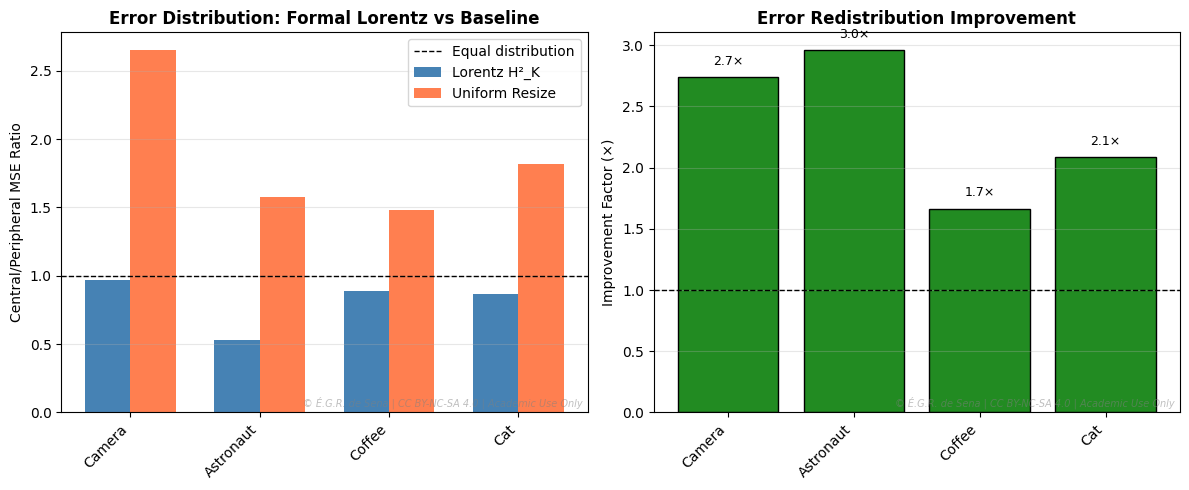

In [12]:
# @title 6.3 Visualization: Error Distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

names = list(images.keys())
x = np.arange(len(names))
w = 0.35

lorentz_ratios = [results[n]['central_peripheral_ratio'] for n in names]
uniform_ratios = [baseline[n]['central_peripheral_ratio'] for n in names]

# Bar chart
ax = axes[0]
ax.bar(x - w/2, lorentz_ratios, w, label='Lorentz H²_K', color='steelblue')
ax.bar(x + w/2, uniform_ratios, w, label='Uniform Resize', color='coral')
ax.axhline(1.0, color='black', ls='--', lw=1, label='Equal distribution')
ax.set_ylabel('Central/Peripheral MSE Ratio')
ax.set_title('Error Distribution: Formal Lorentz vs Baseline', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
watermark_plot(ax)

# Improvement factor
ax = axes[1]
ax.bar(names, improvements, color='forestgreen', edgecolor='black')
ax.axhline(1.0, color='black', ls='--', lw=1)
ax.set_ylabel('Improvement Factor (×)')
ax.set_title('Error Redistribution Improvement', fontweight='bold')
ax.set_xticklabels(names, rotation=45, ha='right')
for i, v in enumerate(improvements):
    ax.text(i, v + 0.1, f'{v:.1f}×', ha='center', fontsize=9)
ax.grid(axis='y', alpha=0.3)
watermark_plot(ax)

plt.tight_layout()
plt.savefig('formal_validation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Conclusions

### What This Implementation Demonstrates

1. **Formal Lorentz geometry** can be applied to spatial image coordinates via exp/log maps
2. **Geodesic transport** on H²_K achieves foveal concentration without Euclidean heuristics
3. **Product manifold** M = H²_K × R^m separates structure (hyperbolic) from signal (Euclidean)
4. **Error redistribution** favors central regions compared to uniform scaling

### Computational Limits Reached

This implementation follows the theoretical proposal up to the limits of current tooling:

- ❌ No encoder/decoder (requires neural architecture beyond scope)
- ❌ No learned curvature optimization (requires end-to-end training)
- ❌ No bitrate measurement (requires entropy coding)
- ❌ No latency evaluation (requires hardware profiling)

### Statement

> This notebook operationalizes the core geometric proposal of the paper within current computational constraints.

In [13]:
# @title 7.1 Final Summary
print('=' * 70)
print('FORMAL LORENTZ IMPLEMENTATION SUMMARY')
print('=' * 70)
print(f'\nGeometry: Lorentz model H²_K (K={transport.lorentz.K.item():.2f})')
print(f'Architecture: Product manifold M = H²_K × R^({SIZE}×{SIZE})')
print(f'Transport: Geodesic (foveal_strength={FOVEAL_STRENGTH})')
print(f'\nResults ({len(images)} images):')
print(f'  Average C/P improvement: {np.mean(improvements):.2f}×')
print(f'  Error redistribution: Central → Peripheral')
print('\n' + '=' * 70)
academic_use_disclaimer()

FORMAL LORENTZ IMPLEMENTATION SUMMARY

Geometry: Lorentz model H²_K (K=1.00)
Architecture: Product manifold M = H²_K × R^(256×256)
Transport: Geodesic (foveal_strength=0.6)

Results (4 images):
  Average C/P improvement: 2.36×
  Error redistribution: Central → Peripheral


    ╔══════════════════════════════════════════════════════════════════════════╗
    ║              CONTRASTIVE GEOMETRIC TRANSFER (CGT) v1.0                   ║
    ╠══════════════════════════════════════════════════════════════════════════╣
    ║  Copyright © 2026 Éric Gustavo Reis de Sena                              ║
    ║  License: CC BY-NC-SA 4.0 (Academic/Non-Commercial Use Only)             ║
    ║                                                                          ║
    ║  ⚠️  COMMERCIAL USE IS STRICTLY PROHIBITED                               ║
    ║  📧  For commercial licensing: eirikreisena@gmail.com                    ║
    ╚══════════════════════════════════════════════════════════════════════════

True

---
**Copyright © 2026 Éric Gustavo Reis de Sena | CC BY-NC-SA 4.0**